# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [35]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,make_scorer
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EDA - Exploratory Data Analysis

### EDA for Portfolio DF

In [16]:
print(portfolio.shape[0],portfolio.shape[1])
portfolio.head(20)

10 6


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
#Distinct channels of offers
listofChannels=list()
for cc in portfolio['channels']:
    listofChannels.extend(cc)

set(listofChannels)

{'email', 'mobile', 'social', 'web'}

In [5]:
#Distinct offer types

portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### EDA for Profile DF

In [7]:
print(profile.shape[0],profile.shape[1])
profile.head(20)

17000 5


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
print(round(profile[profile['gender']=='M'].shape[0]/profile.shape[0]*100,2),'% of all customers are males.')
print(round(profile[profile['gender']=='F'].shape[0]/profile.shape[0]*100,2),'% of all customers are females.')
print(round(profile[~profile['gender'].isin({'M','F'})].shape[0]/profile.shape[0]*100,2),'% of all customers are other or null values.')

49.91 % of all customers are males.
36.05 % of all customers are females.
14.04 % of all customers are other or null values.


In [10]:
print('Average income for male customers is :',round(profile[profile['gender']=='M'].income.mean()))
print('Average income for female customers is :',round(profile[profile['gender']=='F'].income.mean()))
print('Average income for other or not declared gender is:',round(profile[~profile['gender'].isin({'M','F'})].income.mean()))



Average income for male customers is : 61195
Average income for female customers is : 71306
Average income for other or not declared gender is: 63288


In [11]:
null_income=profile[profile['income'].isnull()]
print('Male customers percentage who did not declare income is:'
      ,round((null_income[null_income['gender']=='M'].shape[0]/null_income.shape[0])*100,2))
print('Female customers percentage who did not declare income is:'
      ,round((null_income[null_income['gender']=='F'].shape[0]/null_income.shape[0])*100,2))
print('Other gender percentage who did not declare income is:'
      ,round((null_income[~null_income['gender'].isin({'M','F'})].shape[0]/null_income.shape[0])*100,2))
print("All customers who did not tell gender also did not declare their income too.")

Male customers percentage who did not declare income is: 0.0
Female customers percentage who did not declare income is: 0.0
Other gender percentage who did not declare income is: 100.0
All customers who did not tell gender also did not declare their income too.


### EDA for Transcript DF

In [12]:
print(transcript.shape[0],transcript.shape[1])
transcript.head(20)

306534 4


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [13]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [14]:
print("Percentega of events of the offers in transcript dataframe:",(transcript['event'].value_counts()/transcript.shape[0])*100,end='/n')

Percentega of events of the offers in transcript dataframe: transaction        45.330371
offer received     24.883700
offer viewed       18.831516
offer completed    10.954413
Name: event, dtype: float64/n

In [15]:
transcript[transcript['event']=='transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [16]:
transcript[transcript['event']=='offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
transcript[transcript['event']=='offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [18]:
transcript[transcript['event']=='offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


#### Only when the record event is transaction means that the customers has purchased something or made a transaction and the amount spent will be shown in value column

# Data Visualization

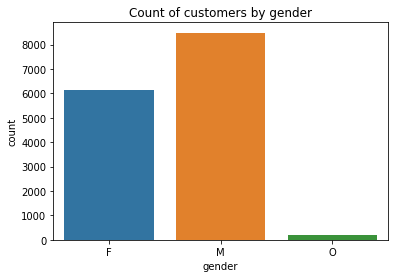

In [19]:
plt.title("Count of customers by gender")
sns.countplot(x='gender',data=profile)

Text(0,0.5,'Avg Age')

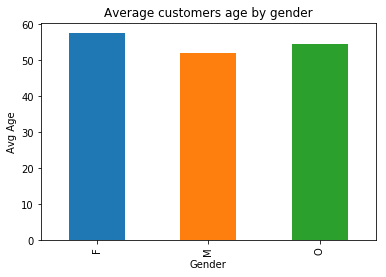

In [20]:
plt.title("Average customers age by gender")
profile.groupby('gender')['age'].mean().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Avg Age')

As we can see , income increases by age


Text(0,0.5,'Avg Income')

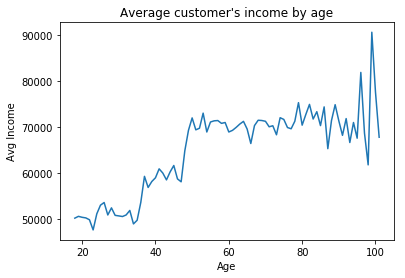

In [21]:
plt.title("Average customer's income by age")
print('As we can see , income increases by age')
profile.groupby('age')['income'].mean().plot(kind='line')
plt.xlabel('Age')
plt.ylabel('Avg Income')

Text(0,0.5,'Count')

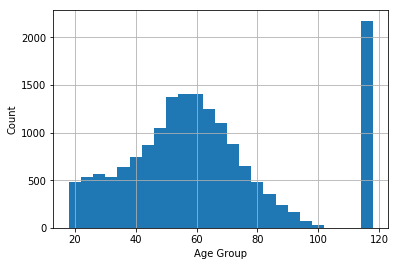

In [22]:
profile.age.hist(bins=25)
plt.xlabel("Age Group")
plt.ylabel("Count")

### As we saw before in EDA part, most of our customers are males then females and then other. We can also say that females have a higher average age than the other 2 categories. We can say that the older the customers the higher their incomes. But later we analysed the whole age groups and count on how many of them fall into these age groups and we can say that most of them have declared an age of 118 which might be a value of null, no declaration of age which makes them outliers.

Text(0,0.5,'Count')

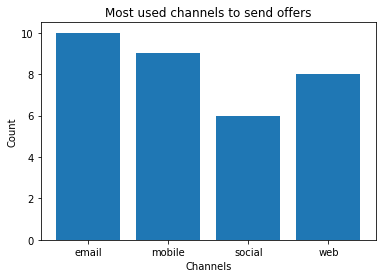

In [23]:
from collections import Counter
channels=[]
for i in portfolio['channels']:
    for j in i:
        channels.append(j)
channels
channels_counts=Counter(channels)
channel_keys=list(channels_counts.keys())
channel_values=list(channels_counts.values())
plt.title("Most used channels to send offers")
plt.bar(channel_keys,channel_values)
plt.xlabel('Channels')
plt.ylabel('Count')

Text(0,0.5,'Count')

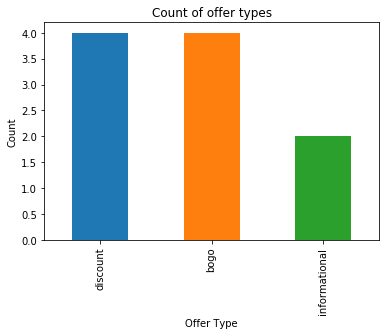

In [24]:
plt.title('Count of offer types')
portfolio['offer_type'].value_counts().plot(kind='bar')
plt.xlabel('Offer Type')
plt.ylabel('Count')

Text(0,0.5,'Reward')

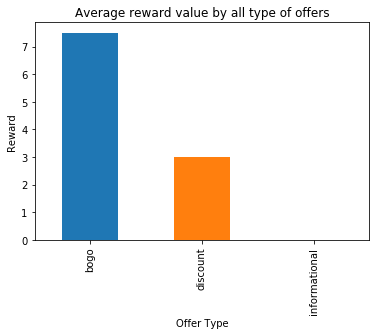

In [25]:
plt.title('Average reward value by all type of offers')
portfolio.groupby('offer_type')['reward'].mean().plot(kind='bar')
plt.xlabel('Offer Type')
plt.ylabel("Reward")

Text(0,0.5,'Duration')

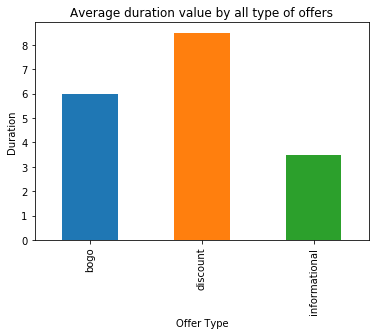

In [26]:
plt.title('Average duration value by all type of offers')
portfolio.groupby('offer_type')['duration'].mean().plot(kind='bar')
plt.xlabel('Offer Type')
plt.ylabel("Duration")

#### There are 4 types of bogos and 4 types of discount while only 2 types of informatonal orders. But when analyzing in terms of total reward that the customer gets from bogos we can see that customers get more from bogos than discounts while informational have a 0 value of reward as expected. But when it comes to duration discounts last more than bogos so customers who get discounts may have more time to spend it than when getting a bogo type of offer.

In [2]:
transcript['value']=transcript['value'].astype(str)
split_values = transcript['value'].str.strip('{}').str.split(':', 1,expand=True)
split_values.columns = ['type_of_val', 'value_of_val']
# Remove leading and trailing whitespaces
split_values['type_of_val'] = split_values['type_of_val'].str.strip().str.replace("'","")
split_values['value_of_val'] = split_values['value_of_val'].str.strip().str.replace("'","")
new_transcript=pd.concat([transcript,split_values],axis=1)
new_transcript.head()

,event,person,time,value,type_of_val,value_of_val
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [3]:
new_transcript['type_of_val'].unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

In [4]:
tt=new_transcript[new_transcript['type_of_val']=='amount']
df=pd.merge(tt,profile,left_on='person',right_on='id',how='left')

df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
df.head()

,event,person,time,value,type_of_val,value_of_val,age,became_member_on,gender,id,income
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},amount,0.8300000000000001,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},amount,34.56,42,2016-01-17,M,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0
2,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},amount,13.23,36,2017-12-28,M,54890f68699049c2a04d415abc25e717,56000.0
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},amount,19.51,55,2017-10-16,F,b2f1cd155b864803ad8334cdf13c4bd2,94000.0
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},amount,18.97,39,2017-12-17,F,fe97aa22dd3e48c8b143116a8403dd52,67000.0


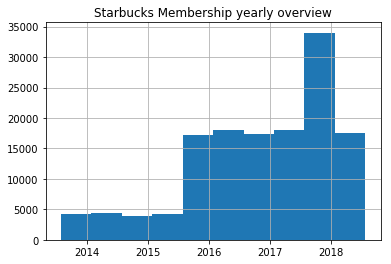

In [30]:
plt.title('Starbucks Membership yearly overview')
df['became_member_on'].hist()

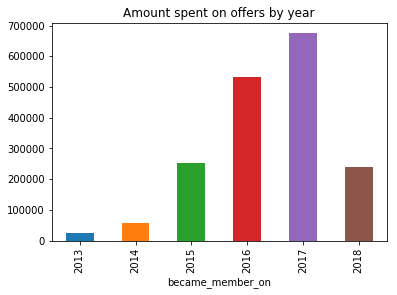

In [31]:
plt.title('Amount spent on offers by year')
non_null_amount=df[df['type_of_val']=='amount']
non_null_amount['value_of_val']=pd.to_numeric(non_null_amount['value_of_val'])
non_null_amount.groupby(non_null_amount['became_member_on'].dt.year)['value_of_val'].sum().plot(kind='bar')

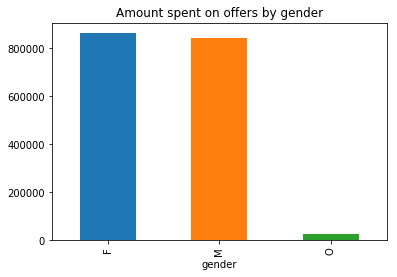

In [32]:
plt.title('Amount spent on offers by gender')
non_null_amount.groupby('gender')['value_of_val'].sum().plot(kind='bar')

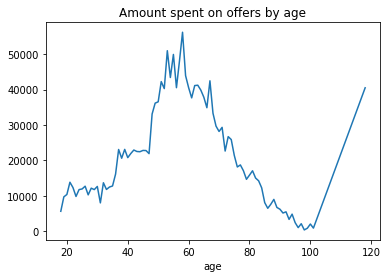

In [33]:
plt.title('Amount spent on offers by age')
non_null_amount.groupby('age')['value_of_val'].sum().plot()

# Data Cleaning 

#### Predicting based on how much a customer will spend then we need the already cleaned and joined dataframe from above df

In [5]:
df.head()

,event,person,time,value,type_of_val,value_of_val,age,became_member_on,gender,id,income
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},amount,0.8300000000000001,20,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},amount,34.56,42,2016-01-17,M,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0
2,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},amount,13.23,36,2017-12-28,M,54890f68699049c2a04d415abc25e717,56000.0
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},amount,19.51,55,2017-10-16,F,b2f1cd155b864803ad8334cdf13c4bd2,94000.0
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},amount,18.97,39,2017-12-17,F,fe97aa22dd3e48c8b143116a8403dd52,67000.0


In [6]:
df.rename(columns={'value_of_val':'amount_spent'},inplace=True)

In [7]:
# finding columns which have null values
print(df.age.value_counts())
print('Gender null values:',df.gender.isnull().sum())
print('Income null values:',df.income.isnull().sum())

118    14996
58      3319
54      2953
51      2911
53      2900
57      2760
55      2754
59      2678
52      2666
63      2594
60      2590
67      2502
56      2445
62      2436
61      2406
49      2376
64      2369
66      2301
48      2281
50      2207
65      2202
68      2042
69      1975
45      1937
40      1894
43      1880
47      1871
39      1848
37      1846
70      1837
       ...  
76      1242
22      1231
75      1181
77      1132
78      1056
31      1013
83       921
80       874
81       861
82       844
79       838
18       699
84       661
87       554
85       545
88       477
89       428
86       408
90       339
91       336
92       323
94       247
93       240
95       159
100      108
97       103
96        47
101       47
98        46
99        35
Name: age, Length: 85, dtype: int64
Gender null values: 14996
Income null values: 14996


In [8]:
df['age'].replace(118,np.nan,inplace=True)

In [9]:
df.age.isnull().sum()

14996

In [10]:
df['age'].fillna(df['age'].mean(), inplace=True)

In [11]:
df.age.isnull().sum()

0

In [12]:
df.loc[df['age'] <= 20, 'age_band']=1 
df.loc[(df['age'] > 20)&(df['age'] <= 40), 'age_band']=2 
df.loc[(df['age'] > 40)&(df['age'] <= 60), 'age_band']=3
df.loc[(df['age'] > 60)&(df['age'] <= 80), 'age_band']=4
df.loc[df['age'] > 80, 'age_band']=4

In [13]:
df.loc[df['gender'] == 'M', 'gender_band']=1 
df.loc[df['gender'] == 'F', 'gender_band']=2
df.loc[df['gender'] == 'O', 'gender_band']=3 

In [14]:
df.gender_band.unique()

array([ 2.,  1., nan,  3.])

In [15]:
df['Year'] = df['became_member_on'].dt.year
df['Month'] = df['became_member_on'].dt.month
df['Day'] = df['became_member_on'].dt.day
df.head()

,event,person,time,value,type_of_val,amount_spent,age,became_member_on,gender,id,income,age_band,gender_band,Year,Month,Day
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},amount,0.8300000000000001,20.0,2016-07-11,F,02c083884c7d45b39cc68e1314fec56c,30000.0,1.0,2.0,2016,7,11
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},amount,34.56,42.0,2016-01-17,M,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0,3.0,1.0,2016,1,17
2,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},amount,13.23,36.0,2017-12-28,M,54890f68699049c2a04d415abc25e717,56000.0,2.0,1.0,2017,12,28
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},amount,19.51,55.0,2017-10-16,F,b2f1cd155b864803ad8334cdf13c4bd2,94000.0,3.0,2.0,2017,10,16
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},amount,18.97,39.0,2017-12-17,F,fe97aa22dd3e48c8b143116a8403dd52,67000.0,2.0,2.0,2017,12,17


In [16]:
df_to_impute=df[['time','amount_spent','age','gender_band','income','age_band','Year','Month','Day']]

In [17]:
knn_imputer=KNNImputer()

df_after_impute=knn_imputer.fit_transform(df_to_impute)

In [18]:
new_df=pd.DataFrame(df_after_impute,columns=df_to_impute.columns)

In [19]:
new_df.head()

,time,amount_spent,age,gender_band,income,age_band,Year,Month,Day
0,0.0,0.83,20.0,2.0,30000.0,1.0,2016.0,7.0,11.0
1,0.0,34.56,42.0,1.0,96000.0,3.0,2016.0,1.0,17.0
2,0.0,13.23,36.0,1.0,56000.0,2.0,2017.0,12.0,28.0
3,0.0,19.51,55.0,2.0,94000.0,3.0,2017.0,10.0,16.0
4,0.0,18.97,39.0,2.0,67000.0,2.0,2017.0,12.0,17.0


In [20]:
new_df['Transaction_frequency'] = df.groupby(['Year', 'Month', 'Day']).transform('count')['time']


In [21]:
new_df.Transaction_frequency.isnull().sum()

0

In [22]:
new_df['IncomeAgeRatio'] = new_df['income'] / new_df['age']

In [23]:
new_df['IsSummer'] = new_df['Month'].isin([6, 7, 8])  #  Summer months


In [24]:
new_df['AmountPerTransaction'] = new_df['amount_spent'] / new_df['Transaction_frequency']


In [25]:
X=new_df[['time','age','income','Year','Month','Day','Transaction_frequency','IncomeAgeRatio','IsSummer','AmountPerTransaction']]
y=new_df[['amount_spent']]
y=y.values.ravel()

In [26]:
X.head()

,time,age,income,Year,Month,Day,Transaction_frequency,IncomeAgeRatio,IsSummer,AmountPerTransaction
0,0.0,20.0,30000.0,2016.0,7.0,11.0,139,1500.000000,True,0.005971
1,0.0,42.0,96000.0,2016.0,1.0,17.0,181,2285.714286,False,0.190939
2,0.0,36.0,56000.0,2017.0,12.0,28.0,155,1555.555556,False,0.085355
3,0.0,55.0,94000.0,2017.0,10.0,16.0,210,1709.090909,False,0.092905
4,0.0,39.0,67000.0,2017.0,12.0,17.0,247,1717.948718,False,0.076802


In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = rf_model.predict(X_test)

# Evaluate the model (for regression, you might use metrics like Mean Squared Error)
mse = mean_squared_error(y_test, predictions)
r2=r2_score(y_test, predictions)
mae=mean_absolute_error(y_test,predictions)

print('Mean Squared Error is:',mse)
print('R2 score is:',r2)
print('Mean Absolute Error is:',mae)

rf_scores=[r2,mse,mae]

Mean Squared Error is: 15.651566438602334
R2 score is: 0.9835297093521707
Mean Absolute Error is: 0.2442438881350925


In [28]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)

gb_model.fit(X_train, y_train)


predictions = gb_model.predict(X_test)


mse = mean_squared_error(y_test, predictions)
r2=r2_score(y_test, predictions)
mae=mean_absolute_error(y_test,predictions)

print('Mean Squared Error is:',mse)
print('R2 score is:',r2)
print('Mean Absolute Error is:',mae)
gb_scores=[r2,mse,mae]

Mean Squared Error is: 11.801363532007455
R2 score is: 0.9875813141019888
Mean Absolute Error is: 0.467415459757932


In [29]:
scaler = StandardScaler()
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped=y_test.reshape(-1, 1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

svr_model = SVR(
    kernel='rbf',          
    C=1.0,                 
    epsilon=0.1            
)


svr_model.fit(X_train_scaled, y_train)

y_pred = svr_model.predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 score is:", r2)

svr_scores=[r2,mse,mae]

Mean Squared Error: 222.6683368804496
Mean Absolute Error: 11.418590885315322
R2 score is: -211.3574116120804


In [30]:
scaler = StandardScaler()
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped=y_test.reshape(-1, 1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)


knn_model = KNeighborsRegressor(
    n_neighbors=5,          
    weights='distance',      
    algorithm='auto'         
)

knn_model.fit(X_train_scaled, y_train_scaled)

y_pred = knn_model.predict(X_test_scaled)

mse = mean_squared_error(y_test_scaled, y_pred)
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 score is:", r2)

knn_scores=[r2,mse,mae]

Mean Squared Error: 0.1237239260162371
Mean Absolute Error: 0.13816591523483576
R2 score is: 0.8820052592506722


In [31]:
#Tabular Representation of models and their evaluations
columns = ['R2 Score', 'Mean Squared Error', 'Mean Absolute Error']
index = ['Random Forest', 'Gradient Boosting', 'SVR', 'KNN']

data = [rf_scores, gb_scores, svr_scores, knn_scores]

score_df = pd.DataFrame(data, columns=columns, index=index)

print(score_df)

                     R2 Score  Mean Squared Error  Mean Absolute Error
Random Forest        0.983530           15.651566             0.244244
Gradient Boosting    0.987581           11.801364             0.467415
SVR               -211.357412          222.668337            11.418591
KNN                  0.882005            0.123724             0.138166


In [36]:
scoring = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error)
}

# Apply cross-validation and print the results
cv_results = cross_validate(rf_model, X=X_train, y=y_train, cv=5, scoring=scoring)

# Create a DataFrame to display the results
cv_results_df = pd.DataFrame({
    'R2 Score': cv_results['test_r2'],
    'Mean Absolute Error': cv_results['test_mae'],
    'Mean Squared Error': cv_results['test_mse']
})

# Display the cross-validation results
print("Cross-Validation Results:")
print(cv_results_df)


Cross-Validation Results:
   R2 Score  Mean Absolute Error  Mean Squared Error
0  0.985868             0.241314           13.571221
1  0.977882             0.243227           19.152206
2  0.983556             0.215480           11.264860
3  0.982300             0.268867           17.844766
4  0.973491             0.291124           26.821930


In [40]:
print('R2 mean after cv=5 is :',cv_results_df['R2 Score'].mean())
print('Mean Absolute Error after cv=5 is :',cv_results_df['Mean Absolute Error'].mean())
print('Mean Squared Error after cv=5 is :',cv_results_df['Mean Squared Error'].mean())

R2 mean after cv=5 is : 0.9806193161780363
Mean Absolute Error after cv=5 is : 0.25200235411024785
Mean Squared Error after cv=5 is : 17.73099678962206


In [59]:
param_grid = {
    'n_estimators':[100,200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10]
}


grid_search = GridSearchCV(RandomForestRegressor( random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}


In [33]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print("Feature importances:", feature_importances)

Feature importances: AmountPerTransaction     0.620201
Transaction_frequency    0.329707
income                   0.043249
time                     0.001846
age                      0.001260
Day                      0.001168
IncomeAgeRatio           0.001162
Year                     0.000564
Month                    0.000562
IsSummer                 0.000282
dtype: float64
